<a href="https://colab.research.google.com/github/kennynlam/DATASCI-112-Final-Project/blob/main/DATASCI%20112%20Final%20Project%20(Machine%20Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATASCI 112 Final Project - Machine Learning**

In this notebook, I constructed 3 different prediction models (KNeighborsRegressor, DecisionTree Regressor, & KernelRidge) to predict a dsitrict's next year enrollment change. Model selection and hyperparameter tuning were utilized to find optimal features, which were all evaluated using cross-validation. I also ensembled my models and tested their performance through VotingRegressor & StackingRegressor.

For clarification, my model is being trained using the 2021-22 district data I previously collected. I decided to test my best 2 models on a different testing set by creating a dataframe of 2020-21 district data with the needed metrics. I then evaluated the RMSE of those models. 



In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from itertools import combinations
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
# reading in the district data file
data_dir = "/content/gdrive/My Drive/Colab Notebooks/DATASCI 112/Final Project/Data Files/"
df_districts = pd.read_csv(data_dir + "df_districts.csv").set_index("District Name")
df_districts

,County Name,Rating Area,2019-20 Enrollment,2020-21 Enrollment,Previous 2 Year Enrollment Change,Previous Year Enrollment Change,Previous 2 Year Population Change,Previous Year Population Change,2021-22 Enrollment,Urban,...,Percent ADA,Math Proficiency Rate,ELA Proficiency Rate,ISPP Index,Percent Free/Reduced Price Lunch,Percent IEP,Percent EL,2022-23 State Enrollment Projection,2022-23 Enrollment,Next Year Enrollment Change
District Name,,,,,,,,,,,,,,,,,,,,,
AGWSR Comm School District,Hardin,1,670.0,699.0,0.029851,-0.012876,-0.008192,-0.010072,690.0,False,...,92.1,0.573171,0.678049,51.372500,0.4311,0.142029,0.011,702.0,650.0,-0.057971
Alden Comm School District,Hardin,1,173.0,169.0,0.034682,0.059172,-0.008192,-0.010072,179.0,False,...,91.3,0.607595,0.670886,56.190000,0.4056,0.128492,0.049,279.0,159.0,-0.111732
Eldora-New Providence Comm School District,Hardin,1,574.0,529.0,-0.097561,-0.020794,-0.008192,-0.010072,518.0,False,...,93.0,0.650519,0.697917,53.070000,0.4235,0.173745,0.017,544.0,540.0,0.042471
Hubbard-Radcliffe Comm School District,Hardin,1,398.0,413.0,-0.057789,-0.092010,-0.008192,-0.010072,375.0,False,...,92.8,0.736434,0.697674,53.635000,0.3983,0.133333,0.011,447.0,377.0,0.005333
Iowa Falls Comm School District,Hardin,1,1314.0,1249.0,-0.029680,0.020817,-0.008192,-0.010072,1275.0,False,...,93.5,0.607692,0.762516,57.357500,0.3898,0.131765,0.031,984.0,1278.0,0.002353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sibley-Ocheyedan Comm School District,Osceola,3,769.0,766.0,-0.050715,-0.046997,0.033736,-0.005329,730.0,False,...,94.5,0.703297,0.746137,51.450000,0.5130,0.126027,0.103,716.0,729.0,-0.001370
South Hamilton Comm School District,Hamilton,1,721.0,688.0,-0.030513,0.015988,0.007717,-0.010107,699.0,False,...,93.2,0.802784,0.849188,61.995000,0.2395,0.092990,0.021,627.0,690.0,-0.012876
Stratford Comm School District,Hamilton,1,65.0,64.0,0.015385,0.031250,0.007717,-0.010107,66.0,False,...,92.9,0.846154,0.846154,54.440000,0.4528,0.106061,0.000,126.0,80.0,0.212121


In [ ]:
df_districts.columns

Index(['County Name', 'Rating Area', '2019-20 Enrollment',
       '2020-21 Enrollment', 'Previous 2 Year Enrollment Change',
       'Previous Year Enrollment Change', 'Previous 2 Year Population Change',
       'Previous Year Population Change', '2021-22 Enrollment', 'Urban',
       'Percent White', 'Percent Hispanic', 'Percent Asian', 'Percent Black',
       'Percent Multi-Race', 'Percent ADA', 'Math Proficiency Rate',
       'ELA Proficiency Rate', 'ISPP Index',
       'Percent Free/Reduced Price Lunch', 'Percent IEP', 'Percent EL',
       '2022-23 State Enrollment Projection', '2022-23 Enrollment',
       'Next Year Enrollment Change'],
      dtype='object')

In [ ]:
# separting categorical variables from quantitative variables
cat_vars = ["Urban", "Rating Area", "County Name"]
quant_vars = ["Previous Year Enrollment Change", "Previous 2 Year Enrollment Change", "Previous Year Population Change", "Previous 2 Year Population Change",
              "Percent White", "Percent Hispanic", "Percent Asian", "Percent Black", "Percent Multi-Race",
              "Percent ADA", "Math Proficiency Rate", "ELA Proficiency Rate", "ISPP Index", "Percent Free/Reduced Price Lunch", "Percent IEP", "Percent EL"]
# list of all variables
vars = ["Urban", "Rating Area", "County Name",
        "Previous Year Enrollment Change", "Previous 2 Year Enrollment Change", "Previous Year Population Change", "Previous 2 Year Population Change",
        "Percent White", "Percent Hispanic", "Percent Asian", "Percent Black", "Percent Multi-Race",
        "Percent ADA", "Math Proficiency Rate", "ELA Proficiency Rate", "ISPP Index", "Percent Free/Reduced Price Lunch", "Percent IEP", "Percent EL"]

In [ ]:
results = pd.DataFrame({"Model": [], "CV RMSE":[]})

# KNeighborsRegressor

In [ ]:
# first k-nearest neighbors model
X_train = df_districts
y_train = df_districts["Next Year Enrollment Change"]
# standardizing quantitative variables, OneHotEncoding categorical variables
col_transform = make_column_transformer(
  (StandardScaler(), quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
)
# using n_neighbors=20 and euclidean distance
pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=20, metric="euclidean")
                         )

cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
).mean()
error = cv ** .5
error
# RMSE is 4.09% (ex. model would predict that a school w/ a 10% next year enrollment increase is actually 6% or 14%)

0.040911851360235195

In [ ]:
# creating a list of all possible quantitative variable combinations
combos = [[]]
quant_vars = ["Previous Year Enrollment Change", "Previous 2 Year Enrollment Change",
              "Previous Year Population Change", "Previous 2 Year Population Change", "Percent White",
              "Percent ADA", "Math Proficiency Rate", "ELA Proficiency Rate", "ISPP Index",
              "Percent Free/Reduced Price Lunch", "Percent IEP", "Percent EL"]

for i in range(3, len(quant_vars) + 1):
  combos.extend(list(combinations(quant_vars, i)))

for i in range(len(combos)):
  combos[i] = list(combos[i])

In [ ]:
# finding the optimal quantitative variable combination w/ all categorical variables
sort = []
for combo in combos:
  col_transform = make_column_transformer(
  (StandardScaler(), combo), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=20, metric="euclidean")
                         )
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  sort.append((combo, cv ** .5))
print(min(sort, key=lambda i:i[1]))
# the quant combination ['Previous 2 Year Enrollment Change', 'Previous 2 Year Population Change', 'Percent ADA', 'Math Proficiency Rate', 'Percent IEP'] is most optimal w/ a RMSE of 3.94%

(['Previous 2 Year Enrollment Change', 'Previous 2 Year Population Change', 'Percent ADA', 'Math Proficiency Rate', 'Percent IEP'], 0.039440441857931496)


In [ ]:
# finding the optimal categorical variable combination w/ the optimal quantitative variable combination
opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Previous 2 Year Population Change', 'Percent ADA', 'Math Proficiency Rate', 'Percent IEP']
cat_combos = [["Urban"], ["Rating Area"], ["County Name"],
              ["Urban", "Rating Area"], ["Urban", "County Name"], ["Rating Area", "County Name"],
              ["Urban", "Rating Area", "County Name"]]
for cat_combo in cat_combos:
  col_transform = make_column_transformer(
  (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_combo),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=20, metric="euclidean")
                         )
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  print((cat_combo, cv ** .5))
# just cat ['Urban'] is most optimal w/ a RMSE of 3.90%

(['Urban'], 0.03902144060581049)
(['Rating Area'], 0.0394923296359545)
(['County Name'], 0.03918145994490033)
(['Urban', 'Rating Area'], 0.03944716768050362)
(['Urban', 'County Name'], 0.03907509209791173)
(['Rating Area', 'County Name'], 0.039531177279674756)
(['Urban', 'Rating Area', 'County Name'], 0.039440441857931496)


<Axes: xlabel='k'>

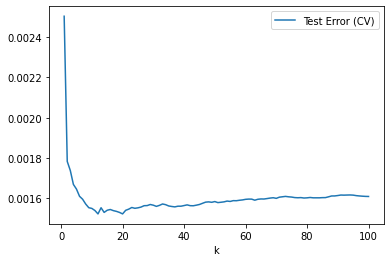

In [ ]:
# graphing CV errors at different ks
mses = []

col_transform = make_column_transformer(
  (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
  remainder="drop")

for k in range(1, 101):
  pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=k, metric="euclidean")
                         )
  mses.append(-cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean())
pd.DataFrame({"Test Error (CV)": mses}, index=range(1,101)).plot(xlabel="k")

In [ ]:
# using GridSearchCV to determine the optimal k & distance metric
grid_cv = GridSearchCV(pipeline,
                       param_grid={
                           "kneighborsregressor__n_neighbors": range(1, 40),
                           "kneighborsregressor__metric": ["euclidean", "manhattan", "cosine", "jaccard"]
                       },
                       scoring="neg_mean_squared_error", cv=10)
grid_cv.fit(X_train, y_train)
grid_cv.best_params_

In [ ]:
col_transform = make_column_transformer(
  (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
  remainder="drop")
pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=12, metric="euclidean")
                         )

cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
).mean()
error = cv ** .5
error
# 12 is the most optimal k & euclidean is the best distance metric w/ a slightly better RMSE 

0.039020876342127364

In [ ]:
# testing different scalers
opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Previous 2 Year Population Change', 'Percent ADA', 'Math Proficiency Rate', 'Percent IEP']
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()]
for scaler in scalers:
  col_transform = make_column_transformer(
    (scaler, opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
    remainder="drop")
  pipeline = make_pipeline(col_transform,
                         KNeighborsRegressor(n_neighbors=12, metric="euclidean"))
  cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  error = cv ** .5
  print(scaler, error)
# StandardScaler() is the most optimal scaler

StandardScaler() 0.039020876342127364
MinMaxScaler() 0.039065967262412196
RobustScaler() 0.039246023694554606
Normalizer() 0.04108787399356759


Overall, the KNeighborsRegressor model produced the best RMSE w/ the following features:
- The variables "Previous 2 Year Enrollment Change", "Previous 2 Year Population Change", "Percent ADA", "Math Proficiency Rate", "Percent IEP", & "Urban"
- n_neighbors = 12
- Euclidean distance metric
- StandardScaler() for quantitative variables

In [ ]:
knn_opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Previous 2 Year Population Change', 'Percent ADA', 'Math Proficiency Rate', 'Percent IEP']
knn_col_transform = make_column_transformer(
    (StandardScaler(), knn_opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
    remainder="drop")
knn_pipeline = make_pipeline(knn_col_transform,
                         KNeighborsRegressor(n_neighbors=12, metric="euclidean"))

In [ ]:
results.loc[0, "Model"] = "KNeighborsRegressor"
results.loc[0, "CV RMSE"] = (-cross_val_score(
    knn_pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()) ** .5
results

,Model,CV RMSE
0,KNeighborsRegressor,0.039021


# DecisionTreeRegressor

In [ ]:
# first decision tree model
X_train = df_districts
y_train = df_districts["Next Year Enrollment Change"]

col_transform = make_column_transformer(
  (StandardScaler(), quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
)
pipeline = make_pipeline(col_transform,
                         DecisionTreeRegressor(random_state=2)
                         )

cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
).mean()
error = cv ** .5
error
# RMSE of 5.38% 

0.053838528558444516

In [ ]:
# finding the optimal quantitative variable combination w/ all categorical variables
combos = []
quant_vars = ["Previous Year Enrollment Change", "Previous 2 Year Enrollment Change",
              "Previous Year Population Change", "Previous 2 Year Population Change", "Percent White",
              "Percent ADA", "Math Proficiency Rate", "ELA Proficiency Rate", "ISPP Index",
              "Percent Free/Reduced Price Lunch", "Percent IEP", "Percent EL"]

for i in range(3, len(quant_vars) + 1):
  combos.extend(list(combinations(quant_vars, i)))

for i in range(len(combos)):
  combos[i] = list(combos[i])

sort = []
for combo in combos:
  col_transform = make_column_transformer(
  (StandardScaler(), combo), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                         DecisionTreeRegressor(random_state=2)
                         )
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  sort.append((combo, cv ** .5))
print(min(sort, key=lambda i:i[1]))
# quant combination ['Previous 2 Year Population Change', 'Percent ADA', 'ISPP Index'] is most optimal w/ a RMSE of 4.49%

In [ ]:
# finding the optimal categorical variable combination w/ the optimal quantitative variable combination
opt_quant_vars = ['Previous 2 Year Population Change', 'Percent ADA', 'ISPP Index']
cat_combos = [["Urban"], ["Rating Area"], ["County Name"],
              ["Urban", "Rating Area"], ["Urban", "County Name"], ["Rating Area", "County Name"],
              ["Urban", "Rating Area", "County Name"]]
for cat_combo in cat_combos:
  col_transform = make_column_transformer(
  (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_combo),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                         DecisionTreeRegressor(random_state=2)
                         )
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  print((cat_combo, cv ** .5))
# cat combination ['Urban', 'Rating Area', 'County Name'] is most optimal w/ a RMSE of 4.49%

(['Urban'], 0.057946212913444026)
(['Rating Area'], 0.05826255126409725)
(['County Name'], 0.04617422950189095)
(['Urban', 'Rating Area'], 0.06043108522071081)
(['Urban', 'County Name'], 0.046258043878382275)
(['Rating Area', 'County Name'], 0.04681298020505862)
(['Urban', 'Rating Area', 'County Name'], 0.04492665172692588)


In [ ]:
# using GridSearchCV to determine the optimal DTR params
col_transform = make_column_transformer(
    (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="drop"
)
pipeline = make_pipeline(col_transform,
                         DecisionTreeRegressor())
grid_cv = GridSearchCV(
     pipeline,
     param_grid={
         "decisiontreeregressor__random_state": range(2, 5),
         "decisiontreeregressor__max_depth": range(1, 10),
         "decisiontreeregressor__min_samples_leaf": range(1, 10),
         "decisiontreeregressor__criterion": ["squared_error", "friedman_mse", "absolute_error"]
     },
     scoring="neg_mean_squared_error", cv=10)
grid_cv.fit(X_train, y_train)
grid_cv.best_params_

In [ ]:
pipeline = make_pipeline(col_transform,
                         DecisionTreeRegressor(criterion="squared_error", max_depth=2, min_samples_leaf=1, random_state=2))
cv = -cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10).mean()
error = cv ** .5
error
# criterion="squared_error", max_depth=2, min_samples_leaf=1, & random_state=2 are optimal params w/ a RMSE of 4.02%

0.04047803035594947

Overall, the DecisionTreeRegressor model produced the best RMSE w/ the following features:
- The variables "Previous 2 Year Population Change", "Percent ADA", "ISPP Index", "Urban", "Rating Area", & "County Name"
- max_depth = 2
- min_samples_leaf = 1
- random_state = 2
- Squared error criterion

In [ ]:
dtr_opt_quant_vars = ['Previous 2 Year Population Change', 'Percent ADA', 'ISPP Index']
dtr_col_transform = make_column_transformer(
    (StandardScaler(), dtr_opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="drop")
dtr_pipeline = make_pipeline(dtr_col_transform,
                         DecisionTreeRegressor(criterion="squared_error", max_depth=2, min_samples_leaf=1, random_state=2))

In [ ]:
results.loc[1, "Model"] = "DecisionTreeRegressor"
results.loc[1, "CV RMSE"] = (-cross_val_score(
    dtr_pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()) ** .5
results

,Model,CV RMSE
0,KNeighborsRegressor,0.039021
1,DecisionTreeRegressor,0.040478


# KernelRidge

In [ ]:
# first KernelRidge model
X_train = df_districts
y_train = df_districts["Next Year Enrollment Change"]

col_transform = make_column_transformer(
  (StandardScaler(), quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
)
pipeline = make_pipeline(col_transform,
                         KernelRidge())

cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
).mean()
error = cv ** .5
error
# RMSE of 4.38% 

0.043360834606399716

In [ ]:
# finding the optimal quantitative variable combination w/ all categorical variables
combos = []
quant_vars = ["Previous Year Enrollment Change", "Previous 2 Year Enrollment Change",
              "Previous Year Population Change", "Previous 2 Year Population Change", "Percent White",
              "Percent ADA", "Math Proficiency Rate", "ELA Proficiency Rate", "ISPP Index",
              "Percent Free/Reduced Price Lunch", "Percent IEP", "Percent EL"]

for i in range(3, len(quant_vars) + 1):
  combos.extend(list(combinations(quant_vars, i)))

for i in range(len(combos)):
  combos[i] = list(combos[i])

sort = []
for combo in combos:
  col_transform = make_column_transformer(
  (StandardScaler(), combo), (OneHotEncoder(handle_unknown="ignore"), cat_vars),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                          KernelRidge())
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  sort.append((combo, cv ** .5))
print(min(sort, key=lambda i:i[1]))
# quant combination ['Previous 2 Year Enrollment Change', 'Percent White', 'Percent Free/Reduced Price Lunch'] is most optimal w/ a RMSE of 4.06%

In [ ]:
opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Percent White', 'Percent Free/Reduced Price Lunch']
cat_combos = [["Urban"], ["Rating Area"], ["County Name"],
              ["Urban", "Rating Area"], ["Urban", "County Name"], ["Rating Area", "County Name"],
              ["Urban", "Rating Area", "County Name"]]
for cat_combo in cat_combos:
  col_transform = make_column_transformer(
  (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), cat_combo),
  remainder="drop"
  )
  pipeline = make_pipeline(col_transform,
                         KernelRidge()
                         )
  cv = -cross_val_score(
      pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  print((cat_combo, cv ** .5))
# just cat ['Urban'] is most optimal w/ a RMSE of 3.999%

(['Urban'], 0.03999292118328663)
(['Rating Area'], 0.04045035102851154)
(['County Name'], 0.04007290284463561)
(['Urban', 'Rating Area'], 0.04047488184986333)
(['Urban', 'County Name'], 0.04011006665234923)
(['Rating Area', 'County Name'], 0.04054572838825751)
(['Urban', 'Rating Area', 'County Name'], 0.04055983899963893)


In [ ]:
# using GridSearchCV to determine the optimal KR params
col_transform = make_column_transformer(
    (StandardScaler(), opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ["Urban"]),
    remainder="drop"
)
pipeline = make_pipeline(col_transform,
                         KernelRidge())
grid_cv = GridSearchCV(
     pipeline,
     param_grid={
         "kernelridge__alpha": range(1, 6),
         'kernelridge__coef0': range(1, 6),
         'kernelridge__degree': range(1, 6)
     },
     scoring="neg_mean_squared_error", cv=10)
grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'kernelridge__alpha': 5, 'kernelridge__coef0': 1, 'kernelridge__degree': 1}

In [ ]:
pipeline = make_pipeline(col_transform,
                         KernelRidge(alpha=5, coef0=1, degree=1))
cv = -cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10).mean()
error = cv ** .5
error
# alpha=5, coef0=1, & degree=1 are optimal params w/ a slightly better RMSE

0.04039776129702508

In [ ]:
# testing different scalers
opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Percent White', 'Percent Free/Reduced Price Lunch']
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()]
for scaler in scalers:
  col_transform = make_column_transformer(
    (scaler, opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
    remainder="drop")
  pipeline = make_pipeline(col_transform,
                           KernelRidge(alpha=5, coef0=1, degree=1))
  cv = -cross_val_score(
    pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()
  error = cv ** .5
  print(scaler, error)
# MinMaxScaler() is the most optimal scaler w/ a RMSE of 3.991%

StandardScaler() 0.03997284017944028
MinMaxScaler() 0.039908464719790385
RobustScaler() 0.0399682920467415
Normalizer() 0.04045249528449006


Overall, the KernelRidge model produced the best RMSE w/ the following features:
- The variables "Previous 2 Year Enrollment Change", "Percent White", "Percent Free/Reduced Price Lunch", & "Urban"
- alpha = 5
- coef0 = 1
- degree = 1 
- MinMaxScaler() for quantitative variables

In [ ]:
kr_opt_quant_vars = ['Previous 2 Year Enrollment Change', 'Percent White', 'Percent Free/Reduced Price Lunch']
kr_col_transform = make_column_transformer(
    (MinMaxScaler(), kr_opt_quant_vars), (OneHotEncoder(handle_unknown="ignore"), ['Urban']),
    remainder="drop")
kr_pipeline = make_pipeline(kr_col_transform,
                           KernelRidge(alpha=5, coef0=1, degree=1))

In [ ]:
results.loc[2, "Model"] = "KernelRidge"
results.loc[2, "CV RMSE"] = (-cross_val_score(
    kr_pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()) ** .5
results

,Model,CV RMSE
0,KNeighborsRegressor,0.039021
1,DecisionTreeRegressor,0.040478
2,KernelRidge,0.039908


# VotingRegressor

In [ ]:
knn_dtr_kr_voter = VotingRegressor([("KNN", knn_pipeline),
                         ("DTR", dtr_pipeline),
                         ("KR", kr_pipeline)])
cv = -cross_val_score(knn_dtr_kr_voter, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 3.92% for KNN/DTR/KR 

0.03920992853092148

In [ ]:
knn_kr_voter = VotingRegressor([("KNN", knn_pipeline),
                         ("KR", kr_pipeline)])
cv = -cross_val_score(knn_kr_voter, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 3.908% for KNN/KR

0.03908083377618095

In [ ]:
knn_dtr_voter = VotingRegressor([("KNN", knn_pipeline),
                         ("DTR", dtr_pipeline)])
cv = -cross_val_score(knn_dtr_voter, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 3.91% for KNN/DTR

0.0391285672710037

In [ ]:
dtr_kr_voter = VotingRegressor([("DTR", dtr_pipeline),
                         ("KR", kr_pipeline)])
cv = -cross_val_score(dtr_kr_voter, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 3.99% for DTR/KR

0.03986579475441149

The best VotingRegressor model ensembled the KNN & KR model.

In [ ]:
results.loc[3, "Model"] = "KNN/KR VotingRegressor"
results.loc[3, "CV RMSE"] = (-cross_val_score(
    knn_kr_voter, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()) ** .5
results

,Model,CV RMSE
0,KNeighborsRegressor,0.039021
1,DecisionTreeRegressor,0.040478
2,KernelRidge,0.039908
3,KNN/KR VotingRegressor,0.039081


# StackingRegressor

In [ ]:
knn_dtr_kr_stacker = StackingRegressor([("KNN", knn_pipeline),
                             ("DTR", dtr_pipeline),
                             ("KR", kr_pipeline)])
cv = -cross_val_score(knn_dtr_kr_stacker, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 3.996% for KNN/DTR/KR

0.039963434790524444

In [ ]:
knn_kr_stacker = StackingRegressor([("KNN", knn_pipeline),
                             ("KR", kr_pipeline)])
cv = -cross_val_score(knn_kr_stacker, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 4.00% for KNN/KR

0.0400277445821952

In [ ]:
knn_dtr_stacker = StackingRegressor([("KNN", knn_pipeline),
                             ("DTR", dtr_pipeline)])
cv = -cross_val_score(knn_dtr_stacker, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 4.01% for KNN/DTR

0.04006962516576426

In [ ]:
dtr_kr_stacker = StackingRegressor([("DTR", dtr_pipeline),
                             ("KR", kr_pipeline)])
cv = -cross_val_score(dtr_kr_stacker, X_train, y_train,
                 scoring="neg_mean_squared_error",
                 cv=10).mean()
error = cv ** .5
error
# RMSE of 4.07% for DTR/KR

0.04070621506980262

The best StackingRegressor ensembled all three pipelines.

In [ ]:
results.loc[4, "Model"] = "KNN/DTR/KR StackingRegressor"
results.loc[4, "CV RMSE"] = (-cross_val_score(
    knn_dtr_kr_stacker, X_train, y_train, scoring="neg_mean_squared_error", cv=10
  ).mean()) ** .5

# Compiled Results

In [ ]:
results

,Model,CV RMSE
0,KNeighborsRegressor,0.039021
1,DecisionTreeRegressor,0.040478
2,KernelRidge,0.039908
3,KNN/KR VotingRegressor,0.039081
4,KNN/DTR/KR StackingRegressor,0.039963


The optimized KNeighborsRegressor model & KNN/KR VotingRegressor model produced the lowest CV RMSEs.

In [ ]:
knn_pipeline.fit(X_train, y_train)
prediction2 = pd.DataFrame({"Predicted Next Year Enrollment Change":knn_pipeline.predict(X_train)}, index=df_districts.index)
prediction2["True Next Year Enrollment Change"] = df_districts["Next Year Enrollment Change"]
prediction2["State Predicted Next Year Enrollment Change"] = (df_districts["2022-23 State Enrollment Projection"] - df_districts["2021-22 Enrollment"]) / df_districts["2021-22 Enrollment"]
prediction2["Predicted Next Year Enrollment"] = (1 + prediction2["Predicted Next Year Enrollment Change"]) * df_districts["2021-22 Enrollment"]
prediction2["True Next Year Enrollment"] = df_districts["2022-23 Enrollment"]

In [ ]:
prediction2

,Predicted Next Year Enrollment Change,True Next Year Enrollment Change,State Predicted Next Year Enrollment Change,Predicted Next Year Enrollment,True Next Year Enrollment
District Name,,,,,
AGWSR Comm School District,-0.018694,-0.057971,0.017391,677.101382,650.0
Alden Comm School District,-0.020420,-0.111732,0.558659,175.344891,159.0
Eldora-New Providence Comm School District,0.005831,0.042471,0.050193,521.020460,540.0
Hubbard-Radcliffe Comm School District,-0.010106,0.005333,0.192000,371.210071,377.0
Iowa Falls Comm School District,-0.000206,0.002353,-0.228235,1274.737503,1278.0
...,...,...,...,...,...
Sibley-Ocheyedan Comm School District,-0.015805,-0.001370,-0.019178,718.461988,729.0
South Hamilton Comm School District,0.008957,-0.012876,-0.103004,705.261241,690.0
Stratford Comm School District,0.030694,0.212121,0.909091,68.025832,80.0


In [ ]:
mean_squared_error(prediction2["Predicted Next Year Enrollment"], prediction2["True Next Year Enrollment"]) ** .5
# current KNN prediction model when applied to enrollment figures has a training error of ~44 students

43.55930349350241

# **Testing My Model on a Different School Year**

# Constructing a DataFrame for 2020-21 School District Metrics

In [ ]:
# creating a df for 2020-21 district data (similar to df_districts), but only with variables that the KNN & VotingRegressor models use
df_districts2021 = pd.DataFrame(index=df_districts.index)
df_districts2021["County Name"] = df_districts["County Name"]
df_districts2021["Urban"] = df_districts["Urban"]
df_districts2021["2020-21 Enrollment"] = df_districts["2020-21 Enrollment"]
df_districts2021["2021-22 Enrollment"] = df_districts["2021-22 Enrollment"]
df_districts2021["Next Year Enrollment Change"] = (df_districts2021["2021-22 Enrollment"] - df_districts2021["2020-21 Enrollment"]) / df_districts2021["2020-21 Enrollment"]

In [ ]:
import requests
response = requests.get("https://data.iowa.gov/resource/qtnr-zsrc.json?$query=SELECT%0A%20%20%60fips%60%2C%0A%20%20%60geographicname%60%2C%0A%20%20%60year%60%2C%0A%20%20%60population%60%2C%0A%20%20%60primary_point%60%2C%0A%20%20%60%3A%40computed_region_hhz5_dst4%60%2C%0A%20%20%60%3A%40computed_region_y683_txed%60%2C%0A%20%20%60%3A%40computed_region_g8ff_h7ce%60%0AWHERE%0A%20%20%60year%60%0A%20%20%20%20BETWEEN%20%222015-11-01T17%3A28%3A08%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222022-03-14T17%3A28%3A08%22%20%3A%3A%20floating_timestamp")
import json
populations = json.loads(response.text)

df_ppy_enrollment = pd.read_csv(data_dir + "2018-19 K12 ENROLLMENT.csv")
df_cy_enrollment = pd.read_csv(data_dir + "2020-21 K12 ENROLLMENT.csv")
df_enrollment_proj = pd.read_csv(data_dir + "STATE ENROLLMENT PROJECTIONS2.csv")
df_ada = pd.read_csv(data_dir + "2020-21 K12 ADA.csv")
df_math = pd.read_csv(data_dir + "2020-21 ISASP MATH.csv").fillna(0)
df_frpl = pd.read_csv(data_dir + "2020-21 FRPL.csv")
df_iep = pd.read_csv(data_dir + "2020-21 IEP.csv")

In [ ]:
need_fix = ["Eddyville-Blakesburg-Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn-Kimballton", "Danville", "Colo-NESCO", "Central DeWitt",
            "Van Buren"]

df_ppy_enrollment.columns = df_ppy_enrollment.iloc[3]
df_ppy_enrollment = df_ppy_enrollment.iloc[4:334, :]
df_ppy_enrollment = df_ppy_enrollment.reset_index()
df_ppy_enrollment.columns.name = ''
df_ppy_enrollment.rename(columns = {'Total PK12':'2018-19 Enrollment', "DISTRICT NAME": "District Name"}, inplace = True)

for district in range(len(df_ppy_enrollment)):
  if df_ppy_enrollment.loc[district, "District Name"] not in need_fix:
    df_ppy_enrollment.loc[district, "District Name"] = df_ppy_enrollment.loc[district, "District Name"] + " Comm School District"
df_ppy_enrollment["District Name"] = df_ppy_enrollment['District Name'].replace({"Eddyville-Blakesburg-Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn-Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District",
                                                                               "Van Buren": "Van Buren County Comm School District"})
df_ppy_enrollment["2018-19 Enrollment"] = df_ppy_enrollment["2018-19 Enrollment"].astype(float)

df_ppy_enrollment = df_ppy_enrollment[["District Name", "2018-19 Enrollment"]]
df_ppy_enrollment

,District Name,2018-19 Enrollment
0,AGWSR Comm School District,656.0
1,Adair-Casey Comm School District,258.0
2,Adel DeSoto Minburn Comm School District,1925.0
3,Akron Westfield Comm School District,639.0
4,Albert City-Truesdale Comm School District,111.0
...,...,...
325,Winfield-Mt Union Comm School District,457.0
326,Winterset Comm School District,1812.0
327,Woodbine Comm School District,505.0
328,Woodbury Central Comm School District,611.0


In [ ]:
need_fix = ["Eddyville-Blakesburg- Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn- Kimballton", "Danville", "Colo-NESCO", "Central DeWitt"]

df_cy_enrollment.columns = df_cy_enrollment.iloc[3]
df_cy_enrollment = df_cy_enrollment.iloc[4:331, :]
df_cy_enrollment = df_cy_enrollment.reset_index()
df_cy_enrollment.columns.name = ''
df_cy_enrollment.rename(columns = {'COUNTY NAME': "County Name", 'Total PK12':'2020-21 Enrollment', "DISTRICT NAME": "District Name"}, inplace = True)
df_cy_enrollment.loc[:, "PK":] = df_cy_enrollment.loc[:, "PK":].replace(",", "", regex=True).astype(float)
df_cy_enrollment["Percent White"] = (df_cy_enrollment["White Total"] / df_cy_enrollment["2020-21 Enrollment"])

for district in range(len(df_cy_enrollment)):
  if df_cy_enrollment.loc[district, "District Name"] not in need_fix:
    df_cy_enrollment.loc[district, "District Name"] = df_cy_enrollment.loc[district, "District Name"] + " Comm School District"
df_cy_enrollment["District Name"] = df_cy_enrollment['District Name'].replace({"Eddyville-Blakesburg- Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn- Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District"})

df_cy_enrollment = df_cy_enrollment[["District Name", "Percent White"]]
df_cy_enrollment

,District Name,Percent White
0,AGWSR Comm School District,0.918455
1,Adair-Casey Comm School District,0.896154
2,Adel DeSoto Minburn Comm School District,0.931754
3,Akron Westfield Comm School District,0.882852
4,Albert City-Truesdale Comm School District,0.769231
...,...,...
322,Winfield-Mt Union Comm School District,0.900485
323,Winterset Comm School District,0.931699
324,Woodbine Comm School District,0.951830
325,Woodbury Central Comm School District,0.950342


In [ ]:
need_fix = ["Eddyville-Blakesburg- Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn- Kimballton", "Danville", "Colo-NESCO", "Central DeWitt"]
        
df_enrollment_proj.columns = df_enrollment_proj.iloc[2]
df_enrollment_proj = df_enrollment_proj.iloc[3:330, :]
df_enrollment_proj = df_enrollment_proj.reset_index()
df_enrollment_proj.columns.name = ''
df_enrollment_proj.rename(columns = {'District Name ': 'District Name', '2021-22': "2021-22 State Enrollment Projection"}, inplace=True)
df_enrollment_proj["2021-22 State Enrollment Projection"] = df_enrollment_proj["2021-22 State Enrollment Projection"].replace(",", "", regex=True).astype(float)

for district in range(len(df_enrollment_proj)):
  if df_enrollment_proj.loc[district, "District Name"] not in need_fix:
    df_enrollment_proj.loc[district, "District Name"] = df_enrollment_proj.loc[district, "District Name"] + " Comm School District"
df_enrollment_proj["District Name"] = df_enrollment_proj['District Name'].replace({"Eddyville-Blakesburg- Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn- Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District"})

df_enrollment_proj = df_enrollment_proj[["District Name", "2021-22 State Enrollment Projection"]]
df_enrollment_proj

,District Name,2021-22 State Enrollment Projection
0,AGWSR Comm School District,653.3
1,Adair-Casey Comm School District,289.9
2,Adel DeSoto Minburn Comm School District,2115.2
3,Akron Westfield Comm School District,628.3
4,Albert City-Truesdale Comm School District,211.4
...,...,...
322,Winfield-Mt Union Comm School District,287.2
323,Winterset Comm School District,1755.2
324,Woodbine Comm School District,444.8
325,Woodbury Central Comm School District,552.5


In [ ]:
need_fix = ["Eddyville-Blakesburg- Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn- Kimballton", "Danville", "Colo-NESCO", "Central DeWitt"]
        
df_ada.columns = df_ada.iloc[4]
df_ada = df_ada.iloc[6:, :]
df_ada = df_ada.reset_index()
df_ada.columns.name = ''
df_ada.rename(columns = {'ADA_%_K12':'Percent ADA'}, inplace=True)

for district in range(len(df_ada)):
  if df_ada.loc[district, "District Name"] not in need_fix:
    df_ada.loc[district, "District Name"] = df_ada.loc[district, "District Name"] + " Comm School District"
df_ada["District Name"] = df_ada['District Name'].replace({"Eddyville-Blakesburg- Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn- Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District"})

df_ada = df_ada[["District Name", "Percent ADA"]]
df_ada

,District Name,Percent ADA
0,AGWSR Comm School District,95.3
1,Adair-Casey Comm School District,96.3
2,Adel DeSoto Minburn Comm School District,94.2
3,Akron Westfield Comm School District,96.3
4,Albert City-Truesdale Comm School District,92.6
...,...,...
322,Winfield-Mt Union Comm School District,94.3
323,Winterset Comm School District,95.7
324,Woodbine Comm School District,96.1
325,Woodbury Central Comm School District,95.3


In [ ]:
df_math.columns = df_math.iloc[5]
df_math.columns.name = ''
df_math = df_math.iloc[6:333, :]
df_math = df_math.drop(columns=[0.0])
df_math = df_math.replace("small N", "1")
df_math.loc[:, "Grade 3 Proficient":] = df_math.loc[:, "Grade 3 Proficient":].replace(",", "", regex=True).astype(float)

proficient = []
total = []
for i in range(3, 12):
  proficient.append("Grade " + str(i) + " Proficient")
  total.append("Grade " + str(i) + " Total Tested")
df_math["Math Proficiency Rate"] = (df_math[proficient].sum(axis=1)) / (df_math[total].sum(axis=1))

df_math = df_math[["District Name", "Math Proficiency Rate"]]
df_math

,District Name,Math Proficiency Rate
6,AGWSR Comm School District,0.610979
7,Adair-Casey Comm School District,0.752874
8,Adel DeSoto Minburn Comm School District,0.773460
9,Akron Westfield Comm School District,0.755051
10,Albert City-Truesdale Comm School District,0.625000
...,...,...
328,Winfield-Mt Union Comm School District,0.564706
329,Winterset Comm School District,0.739739
330,Woodbine Comm School District,0.725086
331,Woodbury Central Comm School District,0.660326


In [ ]:
need_fix = ["Eddyville-Blakesburg- Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn- Kimballton", "Danville", "Colo-NESCO", "Central DeWitt"]

df_frpl.columns = df_frpl.iloc[5]
df_frpl = df_frpl.iloc[6:333]
df_frpl = df_frpl.reset_index()
df_frpl.columns.name = ''
df_frpl.rename(columns = {"District_Name":"District Name"}, inplace=True)
df_frpl["Percent Free/Reduced Price Lunch"] = df_frpl["Percent Free/Reduced Price Lunch"].astype(float) / 100

for district in range(len(df_frpl)):
  if df_frpl.loc[district, "District Name"] not in need_fix:
    df_frpl.loc[district, "District Name"] = df_frpl.loc[district, "District Name"] + " Comm School District"
df_frpl["District Name"] = df_frpl['District Name'].replace({"Eddyville-Blakesburg- Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn- Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District"})

df_frpl = df_frpl[["District Name", "Percent Free/Reduced Price Lunch"]]
df_frpl

,District Name,Percent Free/Reduced Price Lunch
0,AGWSR Comm School District,0.4799
1,Adair-Casey Comm School District,0.4876
2,Adel DeSoto Minburn Comm School District,0.1759
3,Akron Westfield Comm School District,0.2885
4,Albert City-Truesdale Comm School District,0.5049
...,...,...
322,Winfield-Mt Union Comm School District,0.5681
323,Winterset Comm School District,0.3446
324,Woodbine Comm School District,0.3826
325,Woodbury Central Comm School District,0.3063


In [ ]:
need_fix = ["Eddyville-Blakesburg- Fremont", "Central DeWitt", "Decorah Community", "Estherville Lincoln",
            "Olin Consolidated", "West Burlington Ind", "South O'Brien", "South Tama County", "Marion Independent",
            "Janesville Consolidated", "Highland", "Exira-Elk Horn- Kimballton", "Danville", "Colo-NESCO", "Central DeWitt"]

df_iep.columns = df_iep.iloc[2]
df_iep.rename(columns = {'DISTRICT NAME':'District Name'}, inplace=True)
df_iep = df_iep.iloc[3:330]
df_iep = df_iep.reset_index()
df_iep.columns.name = ''
df_iep["Percent IEP"] = (df_iep["All IEP Students"].replace(",", "", regex=True).astype(float) / df_iep["All Students"].replace(",", "", regex=True).astype(float))

for district in range(len(df_iep)):
  if df_iep.loc[district, "District Name"] not in need_fix:
    df_iep.loc[district, "District Name"] = df_iep.loc[district, "District Name"] + " Comm School District"
df_iep["District Name"] = df_iep['District Name'].replace({"Eddyville-Blakesburg- Fremont": "Eddyville-Blakesburg- Fremont CSD",
                                                                               "Decorah Community": "Decorah Community School District",
                                                                               "Estherville Lincoln": "Estherville Lincoln Central Com Sch Dist",
                                                                               "Olin Consolidated": "Olin Consolidated School District",
                                                                               "West Burlington Ind": "West Burlington Ind School District",
                                                                               "South O'Brien": "South O'Brien  Comm School District",
                                                                               "Marion Independent": "Marion Independent School District",
                                                                               "Janesville Consolidated": "Janesville Consolidated School District",
                                                                               "Highland": "Highland  Comm School District",
                                                                               "Exira-Elk Horn- Kimballton": "Exira-Elk Horn- Kimballton Comm Sch Dist",
                                                                               "Danville": "Danville  Comm School District",
                                                                               "Colo-NESCO": "Colo-NESCO  Comm School District",
                                                                               "Central DeWitt": "Central DeWitt School District"})


df_iep = df_iep[["District Name", "Percent IEP"]]
df_iep

,District Name,Percent IEP
0,AGWSR Comm School District,0.147673
1,Adair-Casey Comm School District,0.115702
2,Adel DeSoto Minburn Comm School District,0.090382
3,Akron Westfield Comm School District,0.109319
4,Albert City-Truesdale Comm School District,0.203883
...,...,...
322,Winfield-Mt Union Comm School District,0.096859
323,Winterset Comm School District,0.108818
324,Woodbine Comm School District,0.109620
325,Woodbury Central Comm School District,0.090090


In [ ]:
df_populations = pd.json_normalize(populations)
df_populations.rename(columns={"population": "Population", "geographicname": "County Name", ":@computed_region_hhz5_dst4": "Rating Area", "year": "Year"}, inplace=True)
df_populations["County Name"] = df_populations["County Name"].replace(" County", "", regex=True)
for i in range(len(df_populations["Year"])):
  df_populations["Year"][i] = df_populations["Year"][i][:4]

df_populations2020 = df_populations[df_populations["Year"] == "2020"]
df_populations2018 = df_populations[df_populations["Year"] == "2018"]

df_populations_merged = df_populations2018.merge(df_populations2020, on="County Name", suffixes=(" 2018", " 2020"))
df_populations_merged["Previous 2 Year Population Change"] = (df_populations_merged["Population 2020"].astype(float) - df_populations_merged["Population 2018"].astype(float)) / df_populations_merged["Population 2018"].astype(float)

df_populations_merged = df_populations_merged[["County Name", "Previous 2 Year Population Change"]]
df_populations_merged

,County Name,Previous 2 Year Population Change
0,Jefferson,-0.142035
1,Black Hawk,-0.004396
2,Cedar,-0.003178
3,Greene,-0.021640
4,Audubon,0.037105
...,...,...
94,Pocahontas,0.054215
95,Wayne,0.014364
96,Winnebago,0.013284
97,Madison,0.021103


In [ ]:
df_districts2021 = df_districts2021.merge(df_ppy_enrollment, on="District Name", how="inner")
df_districts2021 = df_districts2021.merge(df_enrollment_proj.merge(df_cy_enrollment.merge(df_ada.merge(df_math.merge(df_frpl.merge(df_iep))))), on="District Name", how="outer")
df_districts2021 = df_districts2021.merge(df_populations_merged, on="County Name", how="outer")
df_districts2021["Previous 2 Year Enrollment Change"] = (df_districts2021["2020-21 Enrollment"] - df_districts2021["2018-19 Enrollment"]) / df_districts2021["2018-19 Enrollment"]
df_districts2021 = df_districts2021[["District Name", "County Name", "2018-19 Enrollment", "Previous 2 Year Enrollment Change", "Previous 2 Year Population Change",
                                     "2020-21 Enrollment", "Urban", "Percent White", "Percent ADA", "Math Proficiency Rate", "Percent Free/Reduced Price Lunch", "Percent IEP",
                                     "2021-22 State Enrollment Projection", "2021-22 Enrollment", "Next Year Enrollment Change"]].fillna(0)
df_districts2021

,District Name,County Name,2018-19 Enrollment,Previous 2 Year Enrollment Change,Previous 2 Year Population Change,2020-21 Enrollment,Urban,Percent White,Percent ADA,Math Proficiency Rate,Percent Free/Reduced Price Lunch,Percent IEP,2021-22 State Enrollment Projection,2021-22 Enrollment,Next Year Enrollment Change
0,AGWSR Comm School District,Hardin,656.0,0.065549,-0.003483,699.0,False,0.918455,95.3,0.610979,0.4799,0.147673,653.3,690.0,-0.012876
1,Alden Comm School District,Hardin,170.0,-0.005882,-0.003483,169.0,False,0.899408,96.6,0.581081,0.3237,0.107914,257.7,179.0,0.059172
2,Eldora-New Providence Comm School District,Hardin,623.0,-0.150883,-0.003483,529.0,False,0.888469,94.1,0.623616,0.4757,0.125506,635.3,518.0,-0.020794
3,Hubbard-Radcliffe Comm School District,Hardin,404.0,0.022277,-0.003483,413.0,False,0.886199,95.5,0.689286,0.4357,0.123360,419.9,375.0,-0.092010
4,Iowa Falls Comm School District,Hardin,1335.0,-0.064419,-0.003483,1249.0,False,0.866293,95,0.625478,0.4394,0.121972,1036.2,1275.0,0.020817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,Sibley-Ocheyedan Comm School District,Osceola,797.0,-0.038896,0.027206,766.0,False,0.768930,95.4,0.752174,0.4979,0.121678,710.1,730.0,-0.046997
323,South Hamilton Comm School District,Hamilton,723.0,-0.048409,0.010278,688.0,False,0.866279,94.2,0.784722,0.2635,0.092450,648.2,699.0,0.015988
324,Stratford Comm School District,Hamilton,79.0,-0.189873,0.010278,64.0,False,0.953125,93.4,0.846154,1.0000,0.142857,134.4,66.0,0.031250
325,Webster City Comm School District,Hamilton,1719.0,0.079116,0.010278,1855.0,False,0.690027,95.2,0.611650,0.4962,0.117273,1816.1,1887.0,0.017251


# Evaluating KNN & KNN/KR Voting Model

In [ ]:
results1 = pd.DataFrame({"Model": [], "Test RMSE":[]})

In [ ]:
X_train_2021 = df_districts2021
y_train_2021 = df_districts2021["Next Year Enrollment Change"]
pipelines = [("KNeighborsRegressor", knn_pipeline), ("KNN/KR VotingRegressor", knn_kr_voter)]

for i in range(len(pipelines)):
  pipelines[i][1].fit(X_train_2021, y_train_2021)
  prediction = pipelines[i][1].predict(X_train_2021)
  mse = mean_squared_error(df_districts2021["Next Year Enrollment Change"], prediction)
  error = mse ** .5
  results1.loc[i, "Model"] = pipelines[i][0]
  results1.loc[i, "Test RMSE"] = error

In [ ]:
results1 = results.merge(results1, on="Model", how="inner")
results1

,Model,CV RMSE,Test RMSE
0,KNeighborsRegressor,0.039021,0.036495
1,KNN/KR VotingRegressor,0.039081,0.036972


Both models had a lower test error. Overall, KNeighborsRegressor produced the lowest CV & test RMSEs. 